# Machine Learning - Project 2: Plant Pathology Classification

Nhóm 11: 

|MSSV|Họ tên|
|:-:|--|
|18120258|Trần Thanh Tùng|
|18120288|Trần Hữu Chí Bảo|
|18120293|Vòng Cảnh Chi|
|18120296|Cao Tất Cường|
|18120339|Hà Văn Duy|


Description:
> https://drive.google.com/file/d/1U65IfdkizLD0pd1aQKp9xqVRnTj5bejR/view

Dataset: plant-pathology-2020-fgvc7

> https://drive.google.com/file/d/1Eg_0c3mvQCu0SpVjLdik1-g1Tuz22ObS/view

Original Colab link:
> https://colab.research.google.com/drive/1Ypg77-WWaohRW_mIce7q2mshGX1vBlk5?usp=sharing

In [ ]:
#!wget -qO- https://drive.google.com/uc?id=1Eg_0c3mvQCu0SpVjLdik1-g1Tuz22ObS > dataset.zip
#!curl -Os https://drive.google.com/uc?id=1Eg_0c3mvQCu0SpVjLdik1-g1Tuz22ObS

# use gdown instead of wget or curl to bypass large file scan (cause by Gdrive)
# https://github.com/wkentaro/gdown

#!pip install gdown > /dev/null
!gdown --id 1Eg_0c3mvQCu0SpVjLdik1-g1Tuz22ObS

# MY BACKUP FILE
#https://drive.google.com/file/d/1v_mpgUH4j5sek1Vt_TOBpcCp8k2I8c0v/view?usp=sharing
#!gdown --id 1v_mpgUH4j5sek1Vt_TOBpcCp8k2I8c0v

Downloading...
From: https://drive.google.com/uc?id=1v_mpgUH4j5sek1Vt_TOBpcCp8k2I8c0v
To: /content/plant-pathology-2020-fgvc7.zip
817MB [00:09, 84.3MB/s]


In [ ]:
!unzip -o plant-pathology-2020-fgvc7.zip >> /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import 

In [ ]:
import pandas as pd
import numpy as np
import warnings
import PIL
from PIL import ImageFilter
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras import datasets, models, layers
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE 
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, Dense, MaxPool2D, Activation, Dropout,Flatten, GlobalAveragePooling2D, Conv2D, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, ResNet50V2, EfficientNetB1, EfficientNetB4

## Read data and split train, validation dataset

In [ ]:
train_df = pd.read_csv('train.csv')
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
test_df = pd.read_csv('test.csv')
test_df.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [ ]:
sample_submission_df = pd.read_csv('sample_submission.csv').head()
sample_submission_df

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


Kiểm tra loại ảnh input cho mô hình:

In [ ]:
extensions = !ls -l images | awk '{print $9}' | sed 's/^.*\.//'
set(extensions)

{'', 'jpg'}

Như vậy dữ liệu ảnh 100% là các file đuôi jpg.

Bởi vì trong các phần làm giàu dữ liệu tiếp sau đây, rất nhiều dữ liệu được sinh ra, vì vậy cần phải tối ưu bộ nhớ nhất có thể, tránh tràn RAM.  
Ta sẽ đan xen giữa việc load ảnh và giải phóng bộ nhớ bằng `gc`, để mọi thứ có thể chạy được.

In [ ]:
import gc # garbage collect(or)
# yoo we can free RAM memory by call gc.collect() after del variables
del sample_submission_df # dont need this variable anymore
gc.collect()

164

Để thuận tiện cho việc huấn luyện, nhóm tách (ngẫu nhiên) một mẫu nhỏ (25%) để làm bộ validation.

In [ ]:
train_df_split, validation_df_split = train_test_split(train_df, test_size=0.25, random_state=42, shuffle=True)

In [ ]:
train_df_split.shape, validation_df_split.shape

((1365, 5), (456, 5))

Đọc ảnh lên từ bộ nhớ và đưa vào RAM

Kích thước ảnh gốc là 2048x1365, rất là lớn, nên ta sẽ rescale lại xuống còn 240x144 (kích thước khá phù hợp để train được mô hình, tránh overfit nhưng vẫn giữ được các thông tin phân lớp quan trọng (features). 

In [ ]:
IMG_SIZE = (240, 160) # (240, 160)

In [ ]:
def pil_image(image_id, resize=False):
    img = PIL.Image.open(f'images/{image_id}.jpg')
    
    if resize:
        img_result = img.resize(IMG_SIZE)
        del img
        return img_result

    return img

Hàm `splitXY` dùng để kết hợp đọc dữ liệu hình ảnh và nhãn tương ứng.  


In [ ]:
def splitXY(input_df):
    """
    Only split, not agument
    return: (X_input, labels)
    """
    labels = []
    X_data = []

    img_ids = input_df.image_id.values
    n = input_df.shape[0]

    print("Processing... %", end="") 
    for i in range(n):
        print(f"\rProcessing... {i+1}/{n}", end="") 
        rows = input_df.iloc[i, :]

        img_path = rows.iloc[0]
        ls = rows.iloc[1:].values
        img = pil_image(img_path, resize=True)

        X_data.append(np.array(img))

        labels.append(ls)

        del img
    
        gc.collect()
        
    print("\nDone.")

    return np.array(X_data, dtype='float32'), np.array(labels, dtype='float32')

In [ ]:
train_X_df, train_labels = splitXY(train_df_split)

Processing... 1365/1365
Done.


In [ ]:
val_X_df, val_labels = splitXY(validation_df_split)

Processing... 456/456
Done.


In [ ]:
train_X_df.shape, val_X_df.shape

((1365, 160, 240, 3), (456, 160, 240, 3))

## Visualize some sample

Lá khỏe mạnh

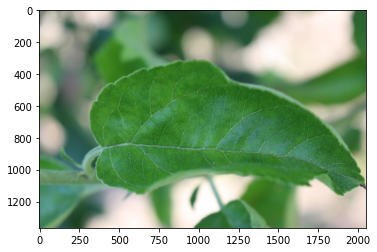

In [ ]:
img = pil_image(train_df.image_id.values[2])
plt.imshow(img)

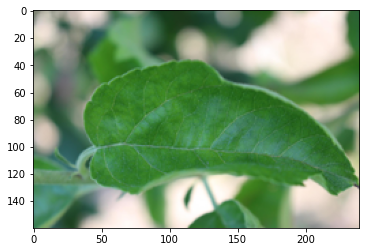

In [ ]:
plt.imshow(pil_image(train_df.image_id.values[2], resize=True))

Lá bị bệnh scab

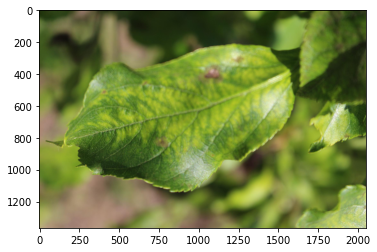

In [ ]:
img = pil_image(train_df.image_id.values[0])
plt.imshow(img)

Lá có bị nhiều bệnh

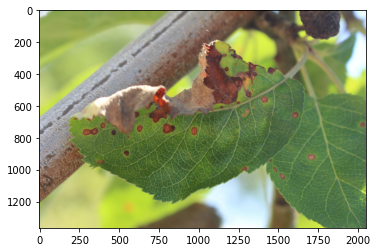

In [ ]:
img = pil_image(train_df.image_id.values[1])
plt.imshow(img)

Lá bị bệnh rust

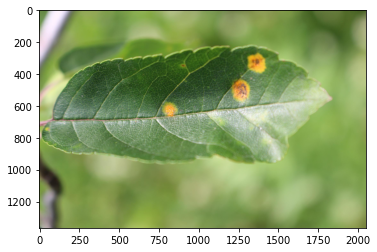

In [ ]:
img = pil_image(train_df.image_id.values[3])
plt.imshow(img)

## Exploring and preprocessing train set

In [ ]:
(train_df.healthy + train_df.multiple_diseases + train_df.rust + train_df.scab).unique()

array([1])

Vậy dữ liệu này chỉ có phân lớp 1 labels

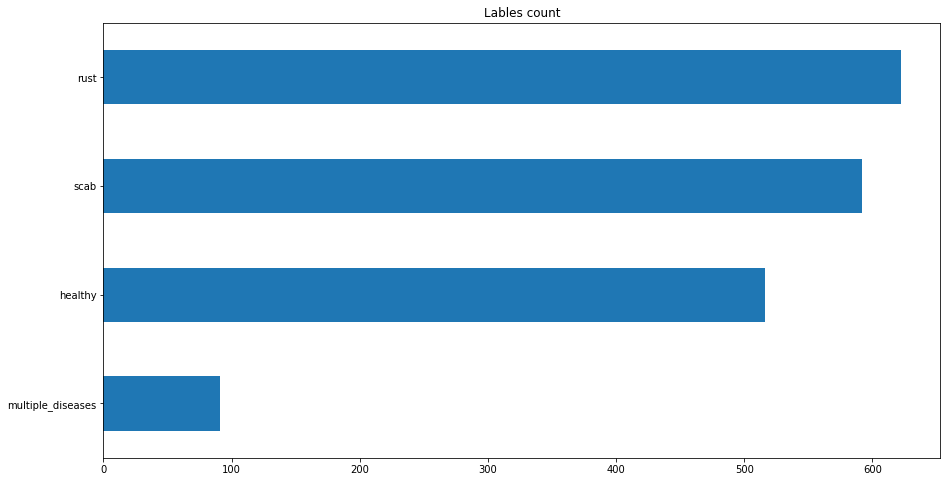

In [ ]:
train_df.iloc[:,1:].sum().sort_values().plot(kind='barh',title='Lables count', figsize=(15,8));

Ta thấy dữ liệu đang bị imbalanced, số mẫu thuộc lớp `multiple_diseases` rất ít so với các lớp còn lại nên ta phải xử lý nó.  
Tập train có 1821 mẫu, quá ít dữ liệu nên không thể  dùng phương pháp undersampling để xử lý mà phải dùng phương pháp oversampling cụ thể là SMOTE (Synthetic Minority Over-sampling Technique)

In [ ]:
warnings.filterwarnings("ignore")
sm = SMOTE(random_state=42) 

(_, h, w, c) = train_X_df.shape

train_X_df, train_labels = sm.fit_resample(train_X_df.reshape((-1, w * h * 3)), train_labels)
train_X_df = train_X_df.reshape((-1, h, w, 3))
train_X_df.shape, train_labels.sum(axis=0)

((1868, 160, 240, 3), array([467, 467, 467, 467]))

Sau khi oversampling thì các mẫu của mỗi nhãn có số lượng như nhau.


## Augumentations


Augumentations là một chiến lược được sử dụng để tăng lượng dữ liệu bằng cách sử dụng các kỹ thuật như cắt xén, đệm, lật, ...

Việc tăng cường dữ liệu làm cho mô hình khó bị overfitting.

### Normal Augmentations

Phương pháp đầu tiên là làm nhiễu ảnh. Không phải tất cả ảnh được chụp đều có độ nét tương đồng, trong thực tế thì một ảnh được chụp trong điều kiện thiếu sáng rất có thể có nhiều nhiễu. Vì vậy ta sẽ dự phòng trường hợp này bằng cách bổ sung các dữ liệu có độ nhiễu cao (từ bộ train) phục vụ cho việc huấn luyện mô hình.  

In [ ]:
def noise_image(pil_im, resize=True):
    # Adding Noise to image
    img_array = np.array(pil_im)
    mean = 0.0   # some constant
    std = 5   # some constant (standard deviation)
    
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    del noisy_img
    del img_array

    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped)) # output

    if resize:
        img_result = noise_img.resize(IMG_SIZE)
        del noise_img

        return img_result

    return np.array(noise_img)

Phương pháp tiếp theo là làm mờ ảnh. Như đã nói ở trên, các hình trong thực tế và trong tương lai có thể được chụp dưới nhiều độ phân giải khác nhau dẫn đến chất lượng khác nhau. Vì thế ta cần thêm loại dữ liệu này cho việc huấn luyện mô hình. 

In [ ]:
def blur_image(pil_im, resize=True):
    #Adding Blur to image 
    
    if isinstance(pil_im, np.ndarray):
        pil_im = PIL.Image.fromarray(pil_im.astype('uint8'))

    blur_img = pil_im.filter(PIL.ImageFilter.GaussianBlur(radius=1)) # output

    if resize:
        img_result = blur_img.resize(IMG_SIZE)
        del blur_img
        
        return img_result

    return np.array(blur_img)

Phương pháp thứ 3 là thay đổi độ tương phản cho ảnh. Các vùng màu tối và sáng sẽ cách nhau rõ rệt hơn nếu như tăng độ tương phản và ngược lại.

In [ ]:
def contrast_image(pil_im, ratio, resize=True):
    #apply contrast ratio to image 
    
    if isinstance(pil_im, np.ndarray):
        pil_im = PIL.Image.fromarray(pil_im.astype('uint8'))

    def contrast(c):
        value = 128 + ratio * (c - 128)
        return max(0, min(255, value))
    
    cons_img = pil_im.point(contrast)

    if resize:
        img_result = cons_img.resize(IMG_SIZE)
        del cons_img
        
        return img_result

    return np.array(cons_img)

Phương pháp sau đây được dùng để khắc phục trường hợp lá cây có nhiều loại và tất nhiên cũng có kết cấu hình dáng khác nhau. Phương pháp này sẽ xoay hình trên một trục phụ ở chiều thứ 3, khiến cho hình chiếu của hình sẽ bị bóp méo để thành hình dạng khác. Điều đó cũng khiến cho bộ train có nhiều dữ liệu mới lạ hơn. 

In [ ]:
def affine_rotation(img, resize=True):

    img = np.array(img)
    rows, columns, chanels = img.shape

    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])

    A = cv2.getAffineTransform(point1, point2)

    output = cv2.warpAffine(img, A, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output)) # affine rotated output

    del output
    del A
    del img

    if resize:
        img_result = affine_img.resize(IMG_SIZE)
        del affine_img
        
        return img_result

    return np.array(affine_img)

Phương pháp này giúp ta chỉ lấy những vùng đặc trưng quan trọng trong hình ảnh (lá cây).

In [ ]:
def gradient_fill(image, resize=True):

    if isinstance(image, np.ndarray):
        image = PIL.Image.fromarray(image.astype('uint8'))

    laplacian = cv2.Laplacian(np.array(image), cv2.CV_64F)
    
    if resize:
        laplacian_result = cv2.resize(laplacian, IMG_SIZE)
        del laplacian
        return laplacian_result

    return np.array(laplacian)

Phương pháp cuối cùng này ngược lại với làm mờ ảnh đã trình bày ở trên, nó làm nét hình ảnh hơn. Trong quá trình làm nét, các cạnh của đối tượng sẽ đồng thời được highlight lên giúp việc quan sát và trích xuất thông tin dễ dàng hơn trên các ảnh bị mờ. 

In [ ]:
def sharpen_image(pil_im, resize=True):

    if isinstance(pil_im, np.ndarray):
        pil_im = PIL.Image.fromarray(pil_im.astype('uint8'))

    enhancer = PIL.ImageEnhance.Sharpness(pil_im)
    
    factor = 2 # factor for sharpen
    sharp_img = enhancer.enhance(factor)

    if resize:
        img_result = sharp_img.resize(IMG_SIZE)
        del sharp_img
        
        return img_result

    return np.array(sharp_img)

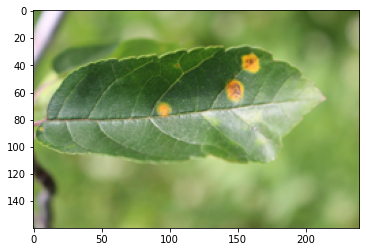

In [ ]:
plt.imshow(noise_image(img))

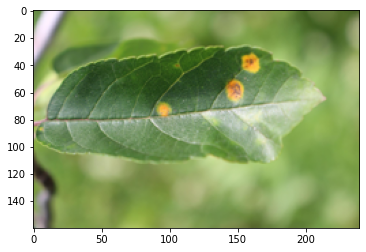

In [ ]:
plt.imshow(blur_image(img))

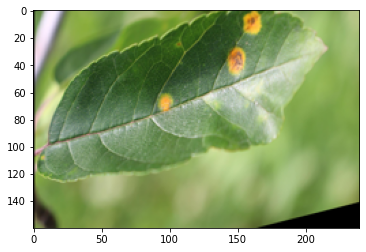

In [ ]:
plt.imshow(affine_rotation(img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


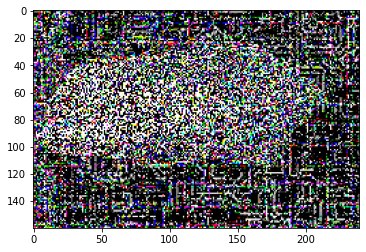

In [ ]:
plt.imshow(gradient_fill(img))

Đến đây ta viết hàm tổng hợp lại các bước làm giàu dữ liệu kể trên, dùng để phát sinh dữ liệu.

In [ ]:
def auguments(imgs, labels_input):
    """
    return: (X_input, labels)
    """
    labels = []
    X_data = []

    n = len(imgs)
    
    print("Processing... %", end="") 
    for i in range(n):

        print(f"\rProcessing... {i+1}/{n}", end="") 
        img, ls = imgs[i], labels_input[i]        

        X_data.append(img)
        labels.append(ls)

        X_data.append(noise_image(img, resize=False))
        labels.append(ls)
        
        X_data.append(blur_image(img, resize=False))
        labels.append(ls)

        X_data.append(contrast_image(img, ratio=1.8, resize=False))
        labels.append(ls)

        X_data.append(affine_rotation(img, resize=False))
        labels.append(ls)

        X_data.append(gradient_fill(img, resize=False))
        labels.append(ls)

        X_data.append(sharpen_image(img, resize=False))
        labels.append(ls)

    print("\nDone.")

    return np.array(X_data, dtype='float32'), np.array(labels, dtype='float32')

In [ ]:
train_X_df_2, train_labels_2 = auguments(train_X_df, train_labels)

Processing... 1868/1868
Done.


### Using Keras Image Data Generator

Với Data Generator API, ta có thể dễ dàng phát sinh dữ liệu động, chỉ phát sinh trong quá trình train, tránh việc chiếm nhiều bộ nhớ. 

In [ ]:
datagen = ImageDataGenerator(rotation_range=45,
                             shear_range=.25,
                             zoom_range=.25,
                             width_shift_range=.25,
                             height_shift_range=.25,
                             rescale=1/255,
                             brightness_range=[.5,1.5],
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest',
                             )

rotation_range: dữ liệu được tạo ra sẽ được xoay ngẫu nhiên theo một góc trong phạm vi +45 đến -45 độ.

shear_range: biến đổi cắt nghiêng hình dạng của hình ảnh.

zoom_range: để thu phóng ảnh một cách ngẫu nhiên.

width_shift_range: hình ảnh sẽ được dịch chuyển ngẫu nhiên, theo hướng sang trái hoặc phải.

height_shift_range: hình ảnh sẽ được dịch chuyển ngẫu nhiên, theo hướng sang lên hoặc xuống.

brightness_range: quy định cụ thể phạm vi để chọn ngẫu nhiên một giá trị thay đổi độ sáng của ảnh.

horizontal_flip và vertical_flip: để lật ảnh theo chiều ngang và chiều dọc.

fill_mode: sau khi xoay ảnh sẽ có các vùng mới màu đen. Ta xử lý các vùng này được bằng cách điền thêm giá trị của pixel gần nhất của hình ảnh gốc.





## Set reduce learning rate and early stopping


In [ ]:
LR_reduce=ReduceLROnPlateau(monitor='val_accuracy',
                            factor=.5,
                            patience=5,
                            min_lr=.000001,
                            verbose=1)

ES_monitor=EarlyStopping(monitor='val_loss',
                          patience=25)

Nếu sau 5 epoch mà `val_accuracy` thì sẽ tự động giảm learning rate và sau 25 epoch mà `val_loss` không giảm thì tự động dừng train.

## Modelling

In [ ]:
def plot_hist(hist):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))
  ax1.plot(hist.history["loss"])
  ax1.plot(hist.history["val_loss"])
  ax1.title.set_text("model loss")
  ax1.set_ylabel("loss")
  ax1.set_xlabel("epoch")
  ax1.legend(["train", "validation"], loc="upper right")

  ax2.plot(hist.history["accuracy"])
  ax2.plot(hist.history["val_accuracy"])
  ax2.title.set_text("model accuracy")
  ax2.set_ylabel("accuracy")
  ax2.set_xlabel("epoch")
  ax2.legend(["train", "validation"], loc="lower right")
  plt.show()

### Train model with data normal augumentations

In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/ML_Labs

/content/drive/.shortcut-targets-by-id/1aRsiVnH1v3IbAGCFeCUeJv4oXEmZQt6W/Colab Notebooks/ML_Labs


#### MLP classifer from scratch

In [ ]:
class MLPClassifier:
    def __init__(self, hidden_layer_sizes=[10], alpha=0.0001, batch=32, max_iter=1000, l2=0.01, random_state=42):
        ''' 
        Class constructor
        We use the sigmoid activation in the hidden layers, and the softmax activation at the output.
        Parameters
        ----------
        hidden_layer_sizes: list number of units of each layers
        alpha: the learning rate determines how big the step would be on each iteration.
        batch: Using batch samples for one times update weight
        max_iter: number of times update weight
        l2: l2 regularization
        '''
        self.hidden_layer_sizes = hidden_layer_sizes
        self.alpha = alpha
        self.batch = batch
        self.max_iter = max_iter
        self.l2 = l2
        self.random_state = random_state
        self.Ws = None
    
    def sigmoid(self, x):
        '''
        Computes sigmoid function for each element of array x.
        '''
        return 1 / (1 + np.exp(-x))
    
    def gradientSigmoid(self, As, Ws ,mb_X, delta, i):
        '''
        Computes gradient vector for sigmoid layer.
        '''
        temp = delta.copy()
        delta = []
        grad = []
        for j in range(i, 0, -1):
            temp = np.multiply(np.dot(temp, self.Ws[j].T), As[j] - np.power(As[j],2))
            temp = temp[:,1:]
            delta.append(temp)
            grad.append(np.dot(As[j-1].T,temp) / len(As[j-1]))
        return delta, grad
    
    
    def softmax(self, z):
        '''
        Computes softmax function for each row of array z.
        '''
        # Subtract the largest value in that column to fix overflow exp.
        A = np.exp(z - np.max(z, axis = 1, keepdims = True))
        A /= A.sum(axis = 1, keepdims=True)

        return A
    
    def gradientSoftmax(self, As, x, y):
        '''
        Computes gradient vector for softmax layer
        '''
        delta = As[-1] - y
        grad = (As[-2].T @ delta)/ len(x)
        return delta, grad

    def computeForwardPropagation(self, Ws, X, need_all_layer_outputs):
        '''
        Computes the outputs of Neural Net by forward propagating X through the network.
        '''
        num_layers = len(self.Ws)
        As = [X]
        a_1 = X
        for i in range(num_layers - 1):
            z = np.dot(a_1, self.Ws[i])  
            a = self.sigmoid(z)
            a = np.append(np.ones((a.shape[0], 1)), a, axis=1)
            As.append(a)
            a_1 = a
        z_last = np.dot(As[-1], self.Ws[-1])
        a_last = self.softmax(z_last)
        As.append(a_last)
        if need_all_layer_outputs:
            return As
        else:
            return As[-1]
    
    def computeLayerSizes(self, X, Y, hid_layer_sizes):
        num_classes = len(np.unique(Y))
        layer_sizes = [X.shape[1]] + hid_layer_sizes + [num_classes]
        return layer_sizes

    def oneHotEncoding(self, Y, num_classes):
        '''
        Y to one hot encoding
        
        Parameters
        ---------
        y: numpy array, shape (m, 1) 
        The vector of outputs.
        
        Return
        y: numpy array, shape (m, num_classes) 
        '''
        one_hot_Y = np.zeros((len(Y), num_classes))
        one_hot_Y[np.arange(len(Y)), Y.reshape(-1)] = 1
        return one_hot_Y
    
    def initWeight(self, X, Y, layer_sizes):
        np.random.seed(self.random_state) 
        self.Ws = np.array([np.random.randn(layer_sizes[i] + 1 , layer_sizes[i + 1]) / np.sqrt(layer_sizes[i] + 1) 
              for i in range(len(layer_sizes) - 1)]) 
    
    def updateWeights(self, Ws, As, mb_X, mb_Y, alpha):
        
        #update weights for softmax layer
        num_hidden_layer = len(self.Ws) - 1
        delta_last , grad_last = self.gradientSoftmax(As, mb_X, mb_Y)
        delta , grad = self.gradientSigmoid(As, self.Ws , mb_X, delta_last, num_hidden_layer)
        self.Ws[-1] -= alpha * (grad_last  + self.l2 * grad_last) / len(mb_X)
        
        #update weights for hidden layer
        grad = grad[::-1]
        for i in range(len(delta)):
            self.Ws[i] -= alpha * (grad[i] + self.l2 * grad[i]) / len(mb_X)

    def fit(self, X, y):
        '''
        Trains MLPClassifier on the dataset (X, y) using mini-batch Gradient Descent.
        
        Parameters
        ----------
        X : numpy array, shape (m, n)
        The matrix of inputs
        y : numpy array, shape (m, 1) 
        The vector of outputs.
        '''
        # Get layer sizes
        layer_sizes = self.computeLayerSizes(X, y, self.hidden_layer_sizes)
        
        # Prepare for training
        self.initWeight(X, y, layer_sizes)
        y = self.oneHotEncoding(y, layer_sizes[-1])
    
        # First column of this matrix is all ones (corresponding to x_0).
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        m, n = X.shape
        
        for iter in range(1, self.max_iter + 1):
            # mix data 
            mix_id = np.random.permutation(m)
            for i in list(range(0, m, self.batch)):
                # Get batch samples
                mb_X = X[mix_id[i : i + self.batch]]
                mb_Y = y[mix_id[i : i + self.batch]]
                
                # Compute forward propagation (all layers)
                As = self.computeForwardPropagation(self.Ws, mb_X, True)
                
                # Back propagation, compute each layer's gradient and update its W
                self.updateWeights(self.Ws, As, mb_X, mb_Y, self.alpha)             
        
    def predict(self, X):
        '''
        Predict using the MLPClassifier model.
        
        Parameters
        ----------
        X : numpy array, shape (m, n)
        The matrix of inputs
        
        Return
        ----------
        Returns predicted values.
        '''
        # First column of this matrix is all ones (corresponding to x_0).
        X = np.append(np.ones((X.shape[0], 1)), X, axis = 1)    
        
        # Compute training info, save it, and print it
        A = self.computeForwardPropagation(self.Ws, X, False)
        return A

def standardScaler(X):
    return (X - np.mean(X)) / np.std(X)

In [ ]:
X = train_X_df_2.reshape(-1,IMG_SIZE[0]*IMG_SIZE[1]*3)
X = standardScaler(X)

y = np.argmax(train_labels_2, axis=-1).reshape(-1,1)
mlp = MLPClassifier(hidden_layer_sizes=[300,200,100], max_iter=2000, alpha=0.05)
mlp.fit(X, y)

#### Baby CNN

Tự cài đặt mô hình mạng tích chập sử dụng các layer và tensors của Keras.

In [ ]:
# call me as baby CNN
baby_CNN = models.Sequential([
                Conv2D(32, (3, 3), activation='relu', input_shape=(160, 240, 3)),
                Conv2D(32, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),
                Conv2D(64, (3, 3), activation='relu'),
                Conv2D(64, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),               
                Conv2D(64, (3, 3), activation='relu'),
                Conv2D(64, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),
                Conv2D(32, (3, 3), activation='relu'),
                Conv2D(32, (3, 3), activation='relu'),

                Flatten(),
                Dense(256, activation='relu'),
                Dense(64, activation='relu'),
                Dense(16, activation='relu'),
                Dense(4, activation = layers.LeakyReLU(alpha=0.01)),
                Dense(4, activation='softmax') # output
])

baby_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 158, 238, 32)      896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 156, 236, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 78, 118, 32)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 76, 116, 64)       18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 74, 114, 64)       36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 57, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 35, 55, 64)       

In [ ]:
baby_CNN.compile(loss='categorical_crossentropy',
                 optimizer='adam', 
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
history_BabyCNN = baby_CNN.fit(train_X_df_2, train_labels_2, epochs=20, 
                               validation_data=(val_X_df, val_labels))

Epoch 1/20
409/409 [==============================] - 34s 80ms/step - loss: 1.3269 - accuracy: 0.3625 - precision_2: 0.7877 - recall_2: 0.0539 - val_loss: 0.9503 - val_accuracy: 0.5482 - val_precision_2: 0.8986 - val_recall_2: 0.2917
Epoch 2/20
409/409 [==============================] - 32s 79ms/step - loss: 0.6626 - accuracy: 0.6856 - precision_2: 0.8006 - recall_2: 0.5355 - val_loss: 0.8978 - val_accuracy: 0.5921 - val_precision_2: 0.6400 - val_recall_2: 0.4561
Epoch 3/20
409/409 [==============================] - 32s 78ms/step - loss: 0.3796 - accuracy: 0.8117 - precision_2: 0.8318 - recall_2: 0.7713 - val_loss: 0.9053 - val_accuracy: 0.6842 - val_precision_2: 0.6957 - val_recall_2: 0.6820
Epoch 4/20
409/409 [==============================] - 32s 78ms/step - loss: 0.1987 - accuracy: 0.9256 - precision_2: 0.9280 - recall_2: 0.9223 - val_loss: 1.2596 - val_accuracy: 0.7522 - val_precision_2: 0.7539 - val_recall_2: 0.7456
Epoch 5/20
409/409 [==============================] - 32s 78ms/s

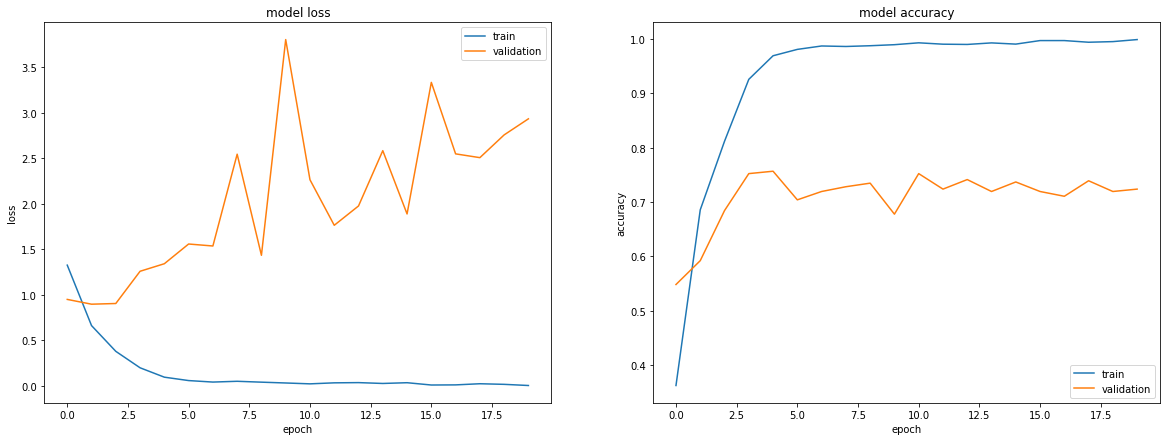

In [ ]:
plot_hist(history_BabyCNN)

#### EfficientNetB1


In [ ]:
input_shape = (160, 240, 3)
efficient_model = EfficientNetB1(include_top=False, weights='imagenet', input_shape=input_shape)
 
efficientNetB1 = models.Sequential()

efficientNetB1.add(layers.InputLayer(input_shape=input_shape))
efficientNetB1.add(layers.experimental.preprocessing.RandomFlip(seed=42))
efficientNetB1.add(layers.experimental.preprocessing.RandomRotation(factor=(-.3, .3), seed=42))
efficientNetB1.add(efficient_model)
 
efficientNetB1.add(layers.Flatten())
efficientNetB1.add(layers.Dense(256, activation='relu'))
efficientNetB1.add(layers.Dense(64, activation='relu'))
efficientNetB1.add(layers.Dense(16, activation = layers.LeakyReLU(alpha=0.01)))
efficientNetB1.add(layers.Dense(4, activation='softmax'))
 
efficientNetB1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 160, 240, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 160, 240, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 5, 8, 1280)        6575239   
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               13107456  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1

In [ ]:
checkpoint = ModelCheckpoint('Models/EfficientNetB1-{epoch:03d}.h5',
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True,
                              mode='auto') # period = 5

In [ ]:
efficientNetB1.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
history_EfficientNetB1 = efficientNetB1.fit(train_X_df_2, train_labels_2, epochs=100,
                    verbose=1,
                    callbacks=[ES_monitor, LR_reduce, checkpoint],
                    validation_data=(val_X_df, val_labels))

Epoch 1/100
409/409 [==============================] - 189s 355ms/step - loss: 0.5333 - accuracy: 0.8101 - precision: 0.8562 - recall: 0.7716 - val_loss: 0.2672 - val_accuracy: 0.9211 - val_precision: 0.9326 - val_recall: 0.9101

Epoch 00001: val_loss improved from inf to 0.26718, saving model to Models/EfficientNetB1-001.h5
Epoch 2/100
409/409 [==============================] - 145s 354ms/step - loss: 0.2637 - accuracy: 0.9148 - precision: 0.9248 - recall: 0.9046 - val_loss: 0.3630 - val_accuracy: 0.9013 - val_precision: 0.9111 - val_recall: 0.8991

Epoch 00002: val_loss did not improve from 0.26718
Epoch 3/100
409/409 [==============================] - 147s 359ms/step - loss: 0.2030 - accuracy: 0.9358 - precision: 0.9432 - recall: 0.9290 - val_loss: 0.2798 - val_accuracy: 0.9298 - val_precision: 0.9332 - val_recall: 0.9189

Epoch 00003: val_loss did not improve from 0.26718
Epoch 4/100
409/409 [==============================] - 146s 357ms/step - loss: 0.1636 - accuracy: 0.9480 - prec

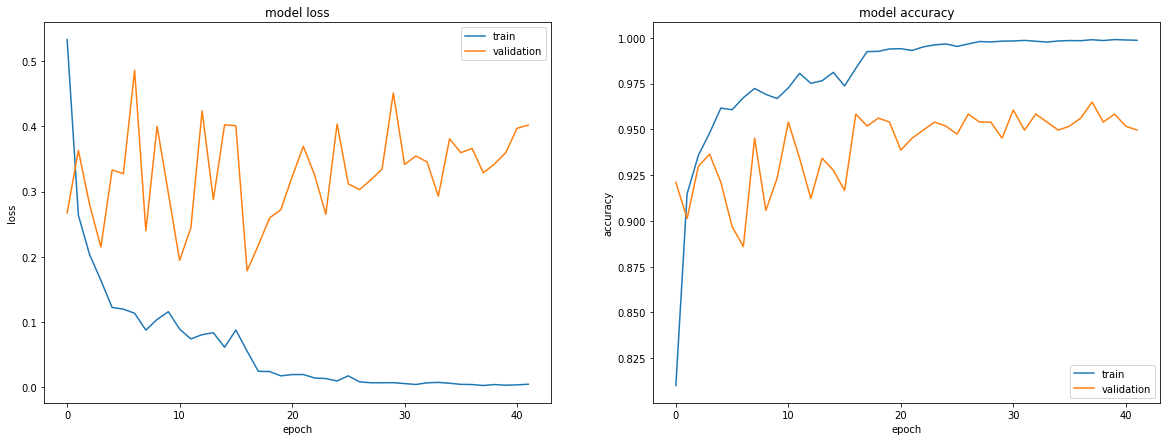

In [ ]:
plot_hist(history_EfficientNetB1)

#### Resnet50V2

In [ ]:
input_shape = (160, 240, 3)
 
resNet50V2_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
 
resNet50V2 = models.Sequential()
resNet50V2.add(layers.InputLayer(input_shape=input_shape))
resNet50V2.add(layers.experimental.preprocessing.RandomFlip(seed=42))
resNet50V2.add(layers.experimental.preprocessing.RandomRotation(factor=(-.3, .3), seed=42))
resNet50V2.add(resNet50V2_model)

resNet50V2.add(layers.GlobalAveragePooling2D())
resNet50V2.add(layers.Dense(256, activation='relu'))
resNet50V2.add(layers.Dense(64, activation='relu'))
resNet50V2.add(layers.Dense(16, activation = layers.LeakyReLU(alpha=0.01)))
resNet50V2.add(layers.Dense(4, activation='softmax'))
 
resNet50V2.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 160, 240, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 160, 240, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 5, 8, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_______________________________________________________

In [ ]:
checkpoint = ModelCheckpoint('Models/ResNet50V2-{epoch:03d}.h5',
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True,
                              mode='auto')

In [ ]:
resNet50V2.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
history_ResNet50V2 = resNet50V2.fit(train_X_df_2, train_labels_2, epochs=100,
                    verbose=1,
                    callbacks=[ES_monitor,LR_reduce, checkpoint],
                    validation_data=(val_X_df, val_labels))

Epoch 1/100
409/409 [==============================] - 110s 249ms/step - loss: 0.7014 - accuracy: 0.7239 - precision_1: 0.7911 - recall_1: 0.6354 - val_loss: 0.9609 - val_accuracy: 0.7566 - val_precision_1: 0.7646 - val_recall_1: 0.7478

Epoch 00001: val_loss improved from inf to 0.96085, saving model to Models/ResNet50V2-001.h5
Epoch 2/100
409/409 [==============================] - 98s 239ms/step - loss: 0.4210 - accuracy: 0.8433 - precision_1: 0.8623 - recall_1: 0.8247 - val_loss: 0.5560 - val_accuracy: 0.8224 - val_precision_1: 0.8367 - val_recall_1: 0.8092

Epoch 00002: val_loss improved from 0.96085 to 0.55600, saving model to Models/ResNet50V2-002.h5
Epoch 3/100
409/409 [==============================] - 98s 240ms/step - loss: 0.3444 - accuracy: 0.8762 - precision_1: 0.8883 - recall_1: 0.8614 - val_loss: 0.4545 - val_accuracy: 0.8596 - val_precision_1: 0.8791 - val_recall_1: 0.8289

Epoch 00003: val_loss improved from 0.55600 to 0.45448, saving model to Models/ResNet50V2-003.h5
E

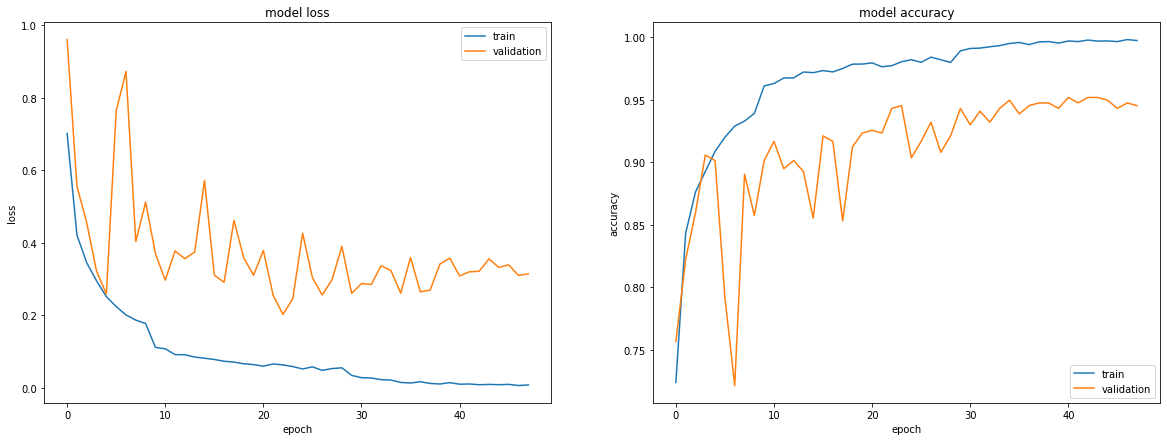

In [ ]:
plot_hist(history_ResNet50V2)

### Train model with data augumentations using Keras Image Data Generator


#### ResNet50

In [ ]:
input_shape = (160, 240, 3)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)
resNet50 = Model(inputs=base_model.input, outputs=predictions)

resNet50.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 240, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 246, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 120, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 120, 64)  256         conv1_conv[0][0]                 
_____________________________

In [ ]:
checkpoint = ModelCheckpoint('Models/ResNet50-{epoch:03d}.h5',
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True,
                              mode='auto')

In [ ]:
resNet50.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
history_ResNet50 = resNet50.fit(datagen.flow(train_X_df, train_labels, batch_size=32),
                              epochs=100,
                              verbose=1,
                              callbacks=[ES_monitor,LR_reduce, checkpoint],
                              validation_data=datagen.flow(val_X_df, val_labels, batch_size=32),
                              )

Epoch 1/100
59/59 [==============================] - 33s 465ms/step - loss: 1.0894 - accuracy: 0.5782 - precision_2: 0.6980 - recall_2: 0.3774 - val_loss: 22.0333 - val_accuracy: 0.2763 - val_precision_2: 0.2763 - val_recall_2: 0.2763

Epoch 00001: val_loss improved from inf to 22.03329, saving model to Models/ResNet50-001.h5
Epoch 2/100
59/59 [==============================] - 25s 427ms/step - loss: 0.6937 - accuracy: 0.7457 - precision_2: 0.7990 - recall_2: 0.6681 - val_loss: 1.5235 - val_accuracy: 0.0482 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00

Epoch 00002: val_loss improved from 22.03329 to 1.52349, saving model to Models/ResNet50-002.h5
Epoch 3/100
59/59 [==============================] - 26s 432ms/step - loss: 0.5567 - accuracy: 0.7971 - precision_2: 0.8234 - recall_2: 0.7612 - val_loss: 1.4656 - val_accuracy: 0.3355 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00

Epoch 00003: val_loss improved from 1.52349 to 1.46560, saving model to Models/ResNet50-00

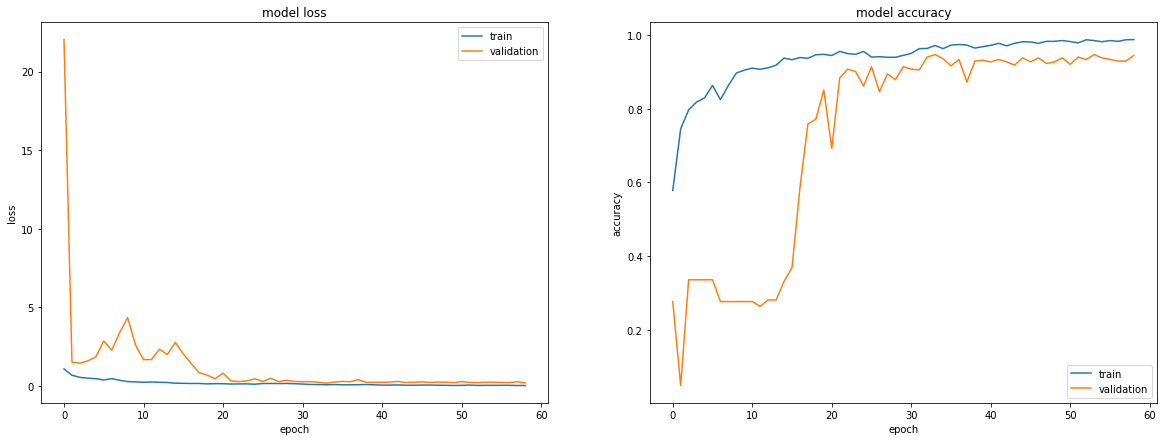

In [ ]:
plot_hist(history_ResNet50)

#### EfficientNetB4

In [ ]:
input_shape = (160, 240, 3)
base_model = EfficientNetB4(weights = 'imagenet', include_top=False, input_shape = input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)
efficientNetB4 = Model(inputs=base_model.input, outputs=predictions)

efficientNetB4.summary()

71688192/71686520 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 240, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 160, 240, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 160, 240, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 161, 241, 3)  0           normalization[0][0]              
_____________________________

In [ ]:
checkpoint = ModelCheckpoint('Models/EfficientNetB4-{epoch:03d}.h5',
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True,
                              mode='auto')

In [ ]:
efficientNetB4.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
history_EfficientNetB4 = efficientNetB4.fit(datagen.flow(train_X_df, train_labels, batch_size=32),
                              epochs=100,
                              verbose=1,
                              callbacks=[ES_monitor,LR_reduce, checkpoint],
                              validation_data=datagen.flow(val_X_df, val_labels, batch_size=32),
                              )

Epoch 1/100
59/59 [==============================] - 92s 737ms/step - loss: 0.8155 - accuracy: 0.6831 - precision: 0.7765 - recall: 0.5728 - val_loss: 1.5214 - val_accuracy: 0.3399 - val_precision: 0.3585 - val_recall: 0.0417

Epoch 00001: val_loss improved from inf to 1.52143, saving model to Models/EfficientNetB4-001.h5
Epoch 2/100
59/59 [==============================] - 39s 661ms/step - loss: 0.4164 - accuracy: 0.8496 - precision: 0.8727 - recall: 0.8217 - val_loss: 1.8678 - val_accuracy: 0.2763 - val_precision: 0.2763 - val_recall: 0.2763

Epoch 00002: val_loss did not improve from 1.52143
Epoch 3/100
59/59 [==============================] - 40s 672ms/step - loss: 0.3754 - accuracy: 0.8721 - precision: 0.8854 - recall: 0.8565 - val_loss: 2.8900 - val_accuracy: 0.2763 - val_precision: 0.2763 - val_recall: 0.2763

Epoch 00003: val_loss did not improve from 1.52143
Epoch 4/100
59/59 [==============================] - 41s 684ms/step - loss: 0.3647 - accuracy: 0.8849 - precision: 0.897

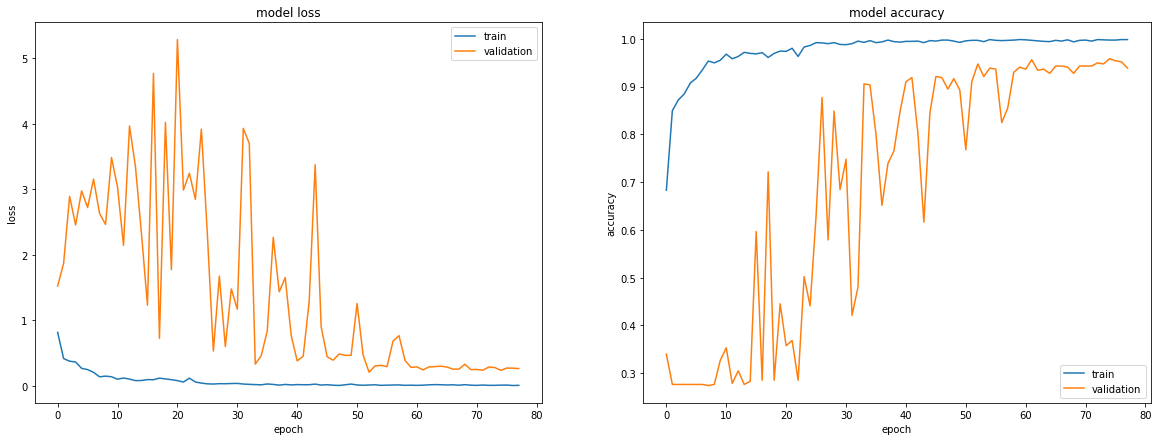

In [ ]:
plot_hist(history_EfficientNetB4)

## Evaluate and test on Kaggle

In [ ]:
model_EfficientNetB1 = models.load_model('Models/best_EfficientNetB1.h5')

In [ ]:
model_ResNetV2 = models.load_model('Models/best_ResNet50V2.h5')

In [ ]:
model_ResNet = models.load_model('Models/best_ResNet50.h5')

In [ ]:
model_EfficientNetB4 = models.load_model('Models/best_EfficientNetB4.h5')

In [ ]:
%cd /content

/content


In [ ]:
print(model_EfficientNetB1.evaluate(val_X_df, val_labels, verbose=2))

15/15 - 1s - loss: 0.1782 - accuracy: 0.9583 - precision: 0.9582 - recall: 0.9561
[0.17816488444805145, 0.9583333134651184, 0.9582417607307434, 0.9561403393745422]


In [ ]:
print(model_ResNetV2.evaluate(val_X_df, val_labels, verbose=2))

15/15 - 1s - loss: 0.2020 - accuracy: 0.9430 - precision_1: 0.9451 - recall_1: 0.9430
[0.20203688740730286, 0.9429824352264404, 0.9450549483299255, 0.9429824352264404]


In [ ]:
print( model_ResNet.evaluate(datagen.flow(val_X_df, val_labels), verbose=2))

15/15 - 4s - loss: 0.2073 - accuracy: 0.9452 - precision_2: 0.9534 - recall_2: 0.9430
[0.2072673887014389, 0.9451754093170166, 0.9534367918968201, 0.9429824352264404]


In [ ]:
print(model_EfficientNetB4.evaluate(datagen.flow(val_X_df, val_labels), verbose=2))

15/15 - 4s - loss: 0.2836 - accuracy: 0.9452 - precision: 0.9473 - recall: 0.9452
[0.28361091017723083, 0.9451754093170166, 0.9472527503967285, 0.9451754093170166]


Ta thấy precision và recall đều cao gần như nhau chứng tỏ các mô hình phân lớp tốt.

In [ ]:
test_ = test_df.copy()
test_['image_id'] = test_['image_id'] + '.jpg'
test_generator=datagen.flow_from_dataframe(test_,directory='./images/',
                                                      target_size=(160, 240),
                                                      x_col="image_id",
                                                      y_col=None,
                                                      class_mode=None,
                                                      shuffle=False,
                                                      batch_size=32,seed=42)

In [ ]:
X_test_fname = test_df.image_id.values
X_test = np.array([np.array(pil_image(p, resize=True)) for p in X_test_fname])

In [ ]:
def gen_submission(model, X_test):
    y_prob = model.predict(X_test)
    submit = pd.DataFrame(data= y_prob, columns=train_df.columns[1:].values)
    submit['image_id'] = X_test_fname

    submission = submit.reindex(columns=train_df.columns)
    return submission

Ta dùng phương pháp voting với 4 model ở trên để hi vọng có kết quả tốt hơn:

In [ ]:
sub_EfficientNetB1 = gen_submission(model_EfficientNetB1, X_test)
sub_ResNetV2 = gen_submission(model_ResNetV2, X_test)
sub_ResNet = gen_submission(model_ResNet, test_generator)
sub_EfficientNetB4 = gen_submission(model_EfficientNetB4, test_generator)

In [ ]:
sub = sub_EfficientNetB1.copy()
sub.iloc[:,1:] = ((sub_EfficientNetB1 + sub_ResNetV2 + sub_ResNet + sub_EfficientNetB4).iloc[:,1:] / 4)

## Result

Kết quả tốt nhất của từng mô hình khi nộp trên [kaggle](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/):
 
- MLP Classifier:
  ![mlp](https://cdn.discordapp.com/attachments/817270986423664670/851050090746478632/submission_mlp.png)  
 
- Baby CNN:
 ![baby](https://cdn.discordapp.com/attachments/817270986423664670/851062992116514816/submission_BabyCNN.png)  
 
---
 
- EfficientNetB1:  
![EffB1](https://cdn.discordapp.com/attachments/817270986423664670/851064390764724224/submission_EfficientNetB1.png)
 
- EfficientNetB4:
 ![EffB4](https://cdn.discordapp.com/attachments/817270986423664670/851050074749403146/submission_EfficientNetB4.png)  
 
- Resnet50: 
![resnet50](https://cdn.discordapp.com/attachments/817270986423664670/851050052142497822/submission_ResNet50.png) 
 
- Resnet50V2: 
![resnet50v2](https://cdn.discordapp.com/attachments/817270986423664670/851063007743311902/submission_ResNet50V2.png)

Kết quả [ensemble](https://cdn.discordapp.com/attachments/817270986423664670/850285217997651998/submission_final.csv) của 4 mô hình tốt nhất: 

![ens](https://media.discordapp.net/attachments/817270986423664670/850283049103261716/plant-pathology-2020-fgvc7-score.png)